In [1]:
from   astropy.table import Table
from   astropy.io    import fits
from   scripts.tools        import *
import matplotlib.pyplot as plt
import numpy as np
obj_lis  = Table.read('obj_lis_selected.fits')

### redshift of selected objs

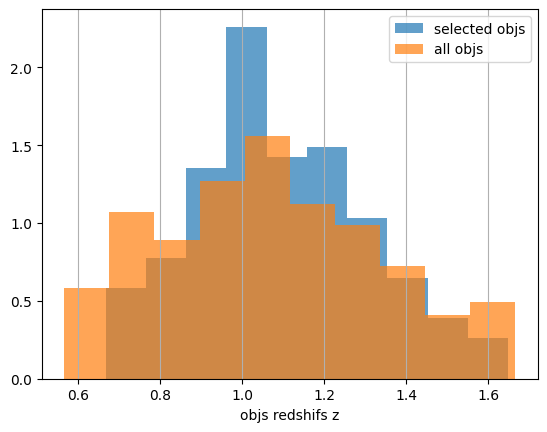

In [2]:
full_object_list = Table.read('full_object_catalog.fits')
obj_with_line = full_object_list[np.logical_and(full_object_list['Ha_FLUX']>0,full_object_list['Hb_FLUX']>0)]


plt.hist(obj_lis['z_MAP'],bins=10,alpha=0.7,density=True,label='selected objs')
plt.hist(obj_with_line['z_MAP'],bins=10,alpha=0.7,density=True,label='all objs')
plt.xlabel('objs redshifs z')
plt.grid(axis='x')
plt.legend()

## SFMS

### the following is the SFMS model from eq3 of Whitaker 2014

In [3]:
#the following is the SFMS model from 
# eq.3 & table 3 of Whitaker 2014
def z_10_15(m_array):
    sfr = np.zeros(len(m_array))
    sfr_err = np.zeros(len(m_array))
    lowmass = m_array<10.2
    sfr[lowmass]     = 0.99 * (m_array[lowmass]-10.2) + 1.31 
    sfr_err[lowmass] = np.sqrt((0.04*(m_array[lowmass]-10))**2 + 0.02**2)
    highmass = m_array >= 10.2  
    sfr[highmass]     = 0.51 * (m_array[highmass]-10.2) + 1.31
    sfr_err[highmass] = np.sqrt((0.07*(m_array[highmass]-10))**2 + 0.02**2)
    return sfr,sfr_err

def z_05_10(m_array):
    sfr = np.zeros(len(m_array))
    sfr_err = np.zeros(len(m_array))
    lowmass = m_array<10.2
    sfr[lowmass]     = 0.94 * (m_array[lowmass]-10.2) + 1.11
    sfr_err[lowmass] = np.sqrt((0.03*(m_array[lowmass]-10))**2 + 0.03**2)
    highmass = m_array >= 10.2  
    sfr[highmass]     = 0.14 * (m_array[highmass]-10.2) + 1.11
    sfr_err[highmass] = np.sqrt((0.08*(m_array[highmass]-10))**2 + 0.03**2)
    return sfr,sfr_err

def SFMS_model(m_min,m_max):
    m = np.linspace(m_min,m_max,30)
    sfr_1_l = z_05_10(m)[0] - z_05_10(m)[1]
    sfr_1_h = z_05_10(m)[0] + z_05_10(m)[1]
    sfr_2_l = z_10_15(m)[0] - z_10_15(m)[1]
    sfr_2_h = z_10_15(m)[0] + z_10_15(m)[1]
    return m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h

### SFMS of selected objects

C:\Users\26715\AppData\Local\Temp\ipykernel_17692\20762454.py:1: RuntimeWarning: invalid value encountered in log10
  logmass = np.log10(obj_lis['mass'])
C:\Users\26715\AppData\Local\Temp\ipykernel_17692\20762454.py:2: RuntimeWarning: invalid value encountered in log10
  logsfr  = np.log10(obj_lis['sfr'])
C:\Users\26715\AppData\Local\Temp\ipykernel_17692\20762454.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(Table.read('full_object_catalog.fits')['mass']),
C:\Users\26715\AppData\Local\Temp\ipykernel_17692\20762454.py:8: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(Table.read('full_object_catalog.fits')['mass']),
C:\Users\26715\AppData\Local\Temp\ipykernel_17692\20762454.py:9: RuntimeWarning: divide by zero encountered in log10
  np.log10(Table.read('full_object_catalog.fits')['sfr']),
C:\Users\26715\AppData\Local\Temp\ipykernel_17692\20762454.py:9: RuntimeWarning: invalid value encountered in log10
  np.log10(Table.read('full_ob

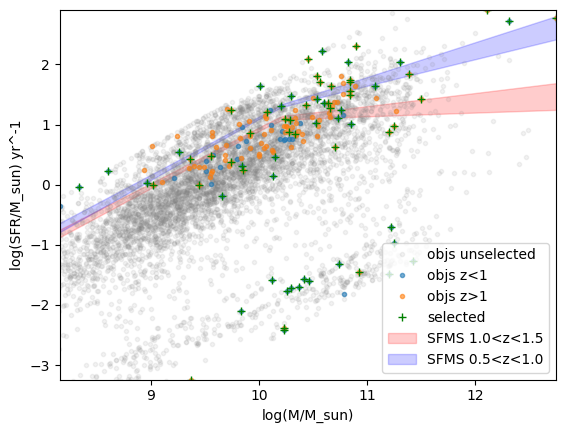

In [4]:
logmass = np.log10(obj_lis['mass'])
logsfr  = np.log10(obj_lis['sfr'])
low_z   = obj_lis['z_MAP']<1.0
high_z  = obj_lis['z_MAP']>1.0
agn     = np.logical_or(obj_lis['tag'] == 'agn',obj_lis['manual_select'] =='selected')
#agn     = obj_lis['tag'] == 'agn'

plt.plot(np.log10(Table.read('full_object_catalog.fits')['mass']),
         np.log10(Table.read('full_object_catalog.fits')['sfr']),
         color='grey',linewidth=0,marker='.',alpha=0.1,label='objs unselected')
plt.plot(logmass[low_z] ,logsfr[low_z], linewidth=0,marker='.',alpha=0.6,label='objs z<1')
plt.plot(logmass[high_z],logsfr[high_z],linewidth=0,marker='.',alpha=0.6,label='objs z>1')
plt.plot(logmass[agn],logsfr[agn],linewidth=0,marker='+',alpha=1,color='g',label='selected')


plt.xlim(np.nanmin(logmass),np.nanmax(logmass))
plt.ylim(np.nanmin(logsfr),np.nanmax(logsfr))

m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h = SFMS_model(np.nanmin(logmass),np.nanmax(logmass))
plt.fill_between(m, sfr_1_l,sfr_1_h, 
                color="r", alpha=0.2,label='SFMS 1.0<z<1.5') 
plt.fill_between(m, sfr_2_l,sfr_2_h, 
                color="b", alpha=0.2,label='SFMS 0.5<z<1.0')
plt.legend()
plt.xlabel('log(M/M_sun)')
plt.ylabel('log(SFR/M_sun) yr^-1')
plt.show()

In [7]:
#here we apply a correction of Nii for Ha +[NII] linemap
# #using Andreas L. Faisst 2018
def nii_ha_ratio(stellar_mass, redshift):
    """
    Calculate the [NII]/Hα flux ratio based on the empirical model by Faisst et al. (2018).
    
    Parameters:
    stellar_mass (float): Stellar mass of the galaxy (in solar masses)
    redshift (float): Redshift (z)
    
    Returns:
    float: Computed [NII]/Hα flux ratio
    """
    import numpy as np

    # Compute the scaled variables
    x = np.log10(stellar_mass) - 10.5
    y = redshift - 2.3

    # Apply the empirical relation
    log_nii_ha = -0.773 + 1.235 * x - 0.281 * x**2 - 0.020 * y + 0.019 * y**2

    # Convert log value to actual ratio
    return 10**log_nii_ha  


def nii_ha_ratio_zahid(stellar_mass, redshift):
    """
    Calculate the [NII]/Hα flux ratio based on the redshift-dependent empirical model by Zahid et al. (2014).

    Parameters:
    stellar_mass (float): Stellar mass of the galaxy (in solar masses)
    redshift (float): Redshift (z)

    Returns:
    float: Computed [NII]/Hα flux ratio
    """
    import numpy as np

    # Convert stellar mass to log scale
    logm = np.log10(stellar_mass)

    # Compute the redshift-dependent coefficient
    a_z = -1.32 + 0.4 * redshift

    # Apply Zahid et al. (2014) empirical relation
    log_nii_ha = a_z + 0.32 * (logm - 10) - 0.05 * (logm - 10)**2

    # Convert log value to actual ratio
    return 10**log_nii_ha



def NII_corr(obj):
    path = f"data_extracted/{file_name(obj,prefix='extracted')}"
    with fits.open(path,mode='update') as hdu:
        ha = find_data('LINE_HA',hdu)[1]
        if 'NII_corr' in ha.header:
            return f"{obj['subfield']}-{obj['ID']} already corrected"
        ha.name = 'LINE_HA'
        ratio = nii_ha_ratio_zahid(obj['mass'],obj['z_MAP'])
        ha.data = ha.data/(1+ratio)
        ha.header['NII_corr'] = str(round(ratio,8))
        save_update(ha,hdu)
        hdu.flush()
        return f"{obj['subfield']}-{obj['ID']} processed"

from    concurrent.futures  import ThreadPoolExecutor, as_completed
from    tqdm                import tqdm
def cat_process(obj_lis, max_threads=1):
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    NII_corr,
                    obj): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(NII_corr(obj))
            return results

def main():
    obj_lis = Table.read('obj_lis_selected.fits')
    
    results = cat_process(obj_lis,max_threads=5)
    errorcounting(results)
    print(results)

if __name__ == '__main__':
    main()


Processing:  13%|█▎        | 21/158 [00:06<00:42,  3.23it/s]C:\Users\26715\AppData\Local\Temp\ipykernel_17692\1550362218.py:41: RuntimeWarning: invalid value encountered in log10
  logm = np.log10(stellar_mass)
Processing: 100%|██████████| 158/158 [00:59<00:00,  2.64it/s]

total number of obj processed: 158
number of failed obj 0
['GN2-11228 processed', 'GN2-10512 processed', 'GN7-12769 processed', 'GN7-11883 processed', 'GN7-11839 processed', 'GN7-13197 processed', 'GN7-13777 processed', 'GN7-13909 processed', 'GN7-14184 processed', 'GN7-13686 processed', 'GN7-14850 processed', 'GN7-14716 processed', 'GN7-15127 processed', 'GN2-14895 processed', 'GN7-14281 processed', 'GN2-16173 processed', 'GN7-15761 processed', 'GN7-16041 processed', 'GN7-15204 processed', 'GN7-15300 processed', 'GN2-17829 processed', 'GN2-17579 processed', 'GN2-16752 processed', 'GN7-17532 processed', 'GN7-17927 processed', 'GN7-19005 processed', 'GN2-18224 processed', 'GN2-18315 processed', 'GN4-19075 processed', 'GN2-18197 processed', 'GN7-19258 processed', 'GN7-19235 processed', 'GN7-19504 processed', 'GN2-21552 processed', 'GN7-19659 processed', 'GN4-21690 processed', 'GN4-22547 processed', 'GN2-21720 processed', 'GN4-22815 processed', 'GN4-23082 processed', 'GN4-26015 processed'